In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from indirect_utils import get_delta, identity

%matplotlib inline

years = [_ for _ in range(1920, 1981)]

In [2]:
data_russian = pd.read_csv("data/russian.csv")
data_itm = pd.read_csv("data/ITM.csv")

In [ ]:
delta_russian_perm = pd.read_csv("delta_russian_perm_gbr.csv")
delta_russian_bootstrap = pd.read_csv("delta_russian_bootstrap_gbr.csv")
pred_russian_full = pd.read_csv("pred_russian_full_gbr.csv")
delta_russian_full_logodds = get_delta(pred_russian_full, use_logodds=True)

In [83]:
delta_itm_perm = pd.read_csv("delta_itm_perm_gbr.csv")
delta_itm_bootstrap = pd.read_csv("delta_itm_bootstrap_gbr.csv")
pred_itm_full = pd.read_csv("pred_itm_full_gbr.csv")
delta_itm_full = get_delta(pred_itm_full, use_logodds=False)

In [84]:
def ci(series, beta=0.95):
    alpha = 1 - beta
    return (series.quantile(alpha / 2), series.quantile(1 - alpha / 2))

In [85]:
def confint(delta_df, beta=0.95):
    return (
        (
            delta_df.groupby("year_of_birth").agg(
                dict(
                    delta=(
                        ("low", lambda x: x.quantile((1 - beta) / 2)),
                        "mean",
                        ("high", lambda x: x.quantile(1 - (1 - beta) / 2)),
                    )
                )
            )
        )
        .droplevel(axis=1, level=0)
        .reset_index()
    )

In [86]:
def typelabel(df, label="type"):
    return df.assign(
        type=lambda x: x["type"].replace({0: "indirect", 1: "direct"})
    ).rename(columns={"type": label})


def plot_pred_data(data, full, target, ylabel, ylim, ylogodds=False):

    plt.figure(figsize=(8, 6))

    def postprocess(df, y, hue):
        df = typelabel(df, hue)
        if ylogodds:
            df = tologodds(df, y)
        return df

    sns.scatterplot(
        x="year_of_birth",
        y="mean",
        size="count",
        hue="collected data",
        ci=None,
        data=(
            data.groupby(["year_of_birth", "type"])[target]
            .agg(("mean", "count"))
            .reset_index()
            .pipe(lambda x: postprocess(x, "mean", "collected data"))
        ),
    )

    sns.lineplot(
        x="year_of_birth",
        y="pred",
        hue="model prediction",
        style="model prediction",
        style_order=["direct", "indirect"],
        data=full.pipe(lambda x: postprocess(x, "pred", "model prediction")),
        ci=None,
    )

    plt.xlabel("Year of birth")
    plt.ylabel(ylabel)
    if ylim:
        plt.ylim(ylim)

In [87]:
def plot_delta(delta_df, delta_full, data, title):
    ci = confint(delta_df)
    minyear = min(delta_full["year_of_birth"])

    fig, (ax1, ax2) = plt.subplots(
        nrows=2, sharex=True, figsize=(10, 7), gridspec_kw=dict(height_ratios=[2, 1])
    )

    ax1.plot(
        ci["year_of_birth"] - minyear, np.zeros_like(ci["year_of_birth"]), color="grey"
    )
    ax1.fill_between(
        ci["year_of_birth"] - minyear, ci["low"], ci["high"], alpha=0.2, color="grey"
    )
    delta_full.groupby("year_of_birth")["delta"].mean().reset_index(drop=True).plot(
        color="red", ax=ax1
    )
    for i in range(5):
        ax1.plot(
            ci["year_of_birth"] - minyear,
            delta_df[lambda x: x["iter"] == i].groupby("year_of_birth")["delta"].mean(),
            color="grey",
            alpha=0.5,
        )
    ax1.set_ylabel("$indirect - direct$")

    sns.countplot(
        x="year_of_birth_int",
        hue="evidence type",
        data=typelabel(
            data_russian.assign(
                year_of_birth_int=lambda x: x["year_of_birth"].astype(int)
            ),
            "evidence type",
        ),
        ax=ax2,
    )

    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
    ax2.set_ylabel("number of observations")
    ax2.set_xlabel("year of birth")
    ax1.set_title(title)

In [88]:
def test_hyp(
    delta_obs,
    delta_null,
    ax,
    stat_column="delta",
    stat_function=identity,
    agg_function=np.mean,
):
    null_distribution = (
        delta_null.groupby("iter")[[stat_column]].agg(agg_function).reset_index()
    )
    stat_value = agg_function(stat_function(delta_obs["delta"]))

    print("statistics value:", stat_value)
    null_distribution[stat_column].hist(bins=50, ax=ax)
    ax.plot([stat_value], [5], "o", markersize=10)
    pvalue = (
        null_distribution.assign(
            in_tail=lambda x: (
                ((stat_value > x[stat_column].mean()) & (x[stat_column] > stat_value))
                | ((stat_value < x[stat_column].mean()) & (x[stat_column] < stat_value))
            )
        )["in_tail"].mean()
        * 2
    )
    return stat_value, pvalue
    # ax.set_title(f"Statistics value: {stat_value:0.4f}, p-value: {pvalue:0.4f}")

In [89]:
def test_all_hyps(
    delta_full,
    delta_df,
    statistics=(
        ("mean(·)", "delta", identity, np.mean),
        ("mean(abs(·))", "delta_absolute", np.abs, np.mean),
    ),
    queries=(None, "year_of_birth <= 1945", "year_of_birth > 1945"),
    suptitle=None,
    figsize=(12, 8),
):

    fig, axes = plt.subplots(
        len(statistics), len(queries), figsize=figsize, squeeze=False
    )
    emptyquery = "index == index or index != index"
    for i, (stat_name, stat_column, stat_function, agg_function) in enumerate(
        statistics
    ):
        for j, query in enumerate(queries):
            query_actual = query if query else emptyquery
            query_name = query.replace("<=", "≤") if query else "Full dataset"

            stat_value, pvalue = test_hyp(
                delta_obs=delta_full.query(query_actual),
                delta_null=delta_df.query(query_actual),
                stat_column=stat_column,
                stat_function=stat_function,
                agg_function=agg_function,
                ax=axes[i, j],
            )
            axes[i, j].set_title(
                f"{query_name}\n"
                #                                 f"{stat_name}\n"
                f"pvalue = {pvalue}"
            )
    if suptitle:
        fig.suptitle(suptitle)

## Russian

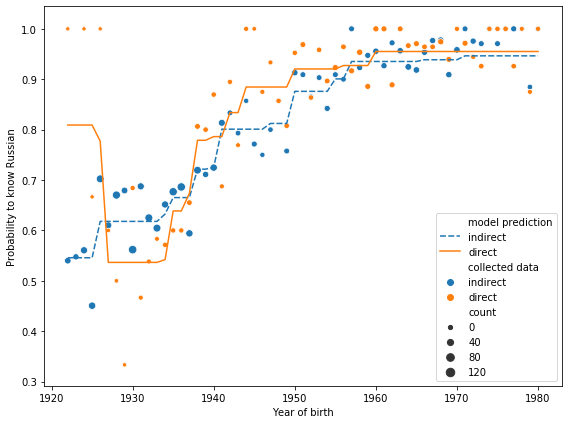

In [90]:
plot_pred_data(
    data=data_russian,
    full=pred_russian_full,
    target="русский",
    ylabel="Probability to know Russian",
    ylim=None,
    ylogodds=False,
)
plt.tight_layout()
# plt.savefig("plot_pred_data_rusian.png")

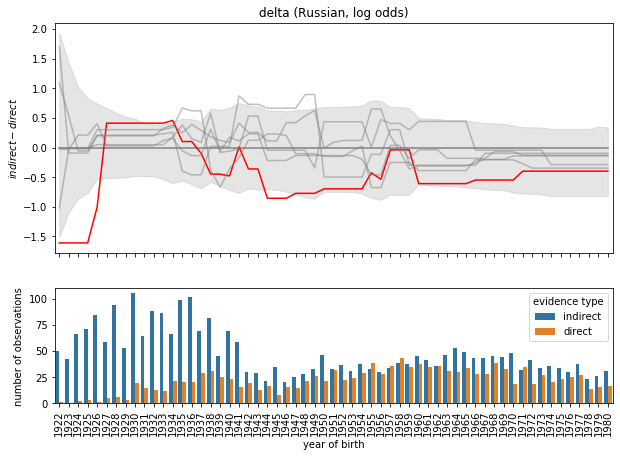

In [91]:
plot_delta(
    delta_russian_perm,
    delta_russian_full_logodds,
    data_russian,
    title="delta (Russian, log odds)",
)

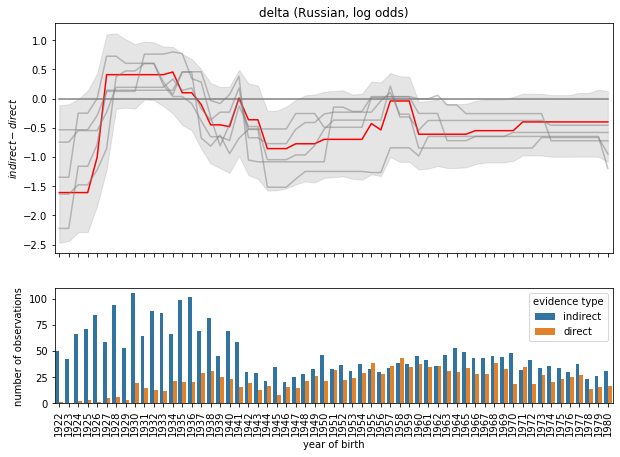

In [92]:
plot_delta(
    delta_russian_bootstrap,
    delta_russian_full_logodds,
    data_russian,
    title="delta (Russian, log odds)",
)

statistics value: -0.4389703938360903
statistics value: -0.3248201709460544
statistics value: -0.5172448323892578


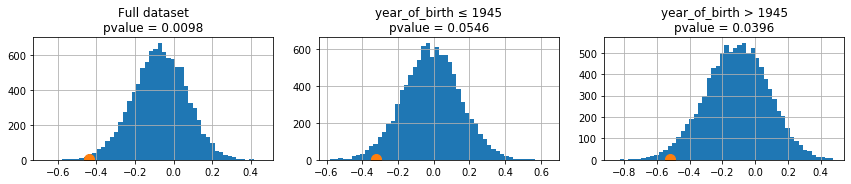

In [93]:
test_all_hyps(
    delta_russian_full_logodds,
    delta_russian_perm,
    statistics=(("systematic bias", "delta", identity, np.mean),),
    queries=(None, "year_of_birth <= 1945", "year_of_birth > 1945"),
    figsize=(12, 8 / 3),
)
plt.tight_layout()
plt.savefig("russian-systematic-bias.png")

In [79]:
ci(delta_russian_bootstrap.groupby("iter")["delta"].mean())

(-0.760516955238272, -0.1728884347428068)

In [95]:
2

2

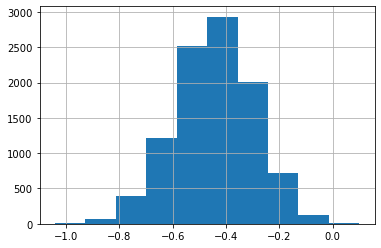

In [97]:
delta_russian_bootstrap.groupby("iter")["delta"].mean().hist()

## ITM

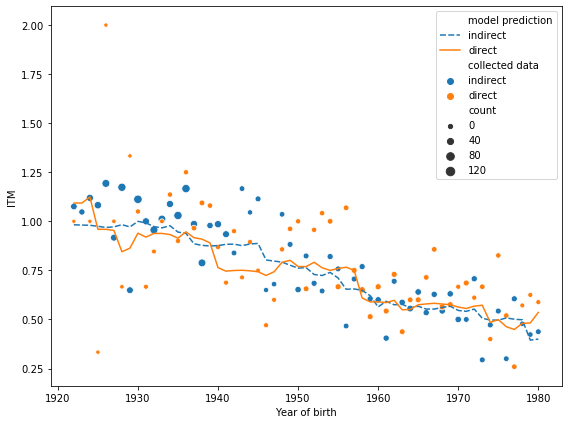

In [67]:
plot_pred_data(
    data=data_itm,
    full=pred_itm_full,
    target="number of lang",
    ylabel="ITM",
    ylim=None,
    ylogodds=False,
)
plt.tight_layout()
# plt.savefig("plot_pred_data_rusian.png")

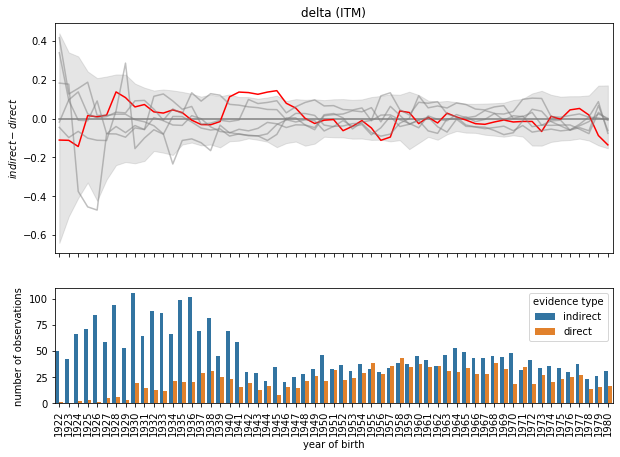

In [68]:
plot_delta(delta_itm_perm, delta_itm_full, data_itm, title="delta (ITM)")

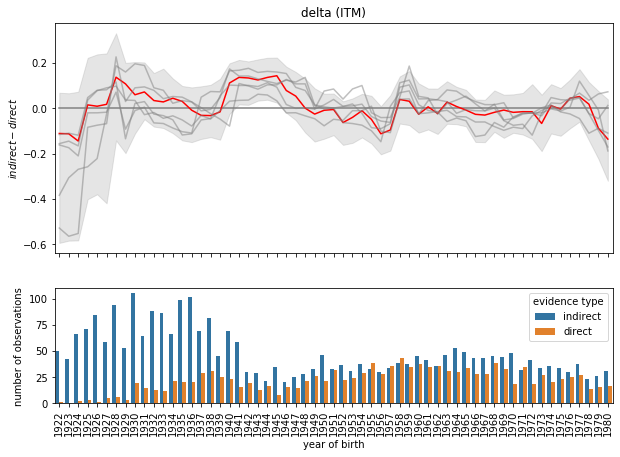

In [69]:
plot_delta(delta_itm_bootstrap, delta_itm_full, data_itm, title="delta (ITM)")

statistics value: 0.006613578387806378
statistics value: 0.03737358509603521
statistics value: -0.014478997640693393


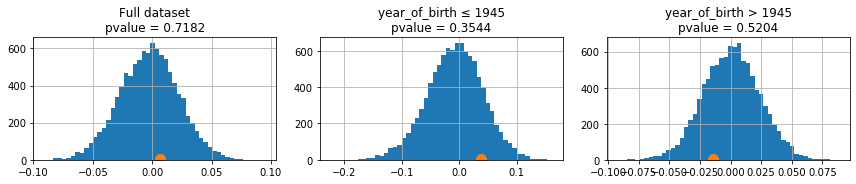

In [70]:
test_all_hyps(
    delta_itm_full,
    delta_itm_perm,
    statistics=(("systematic bias", "delta", identity, np.mean),),
    figsize=(12, 8 / 3),
)
plt.tight_layout()
plt.savefig("itm-systematic-bias.png")

statistics value: 0.18044391132848042
statistics value: 0.22920706029622456
statistics value: 0.1470063234648844


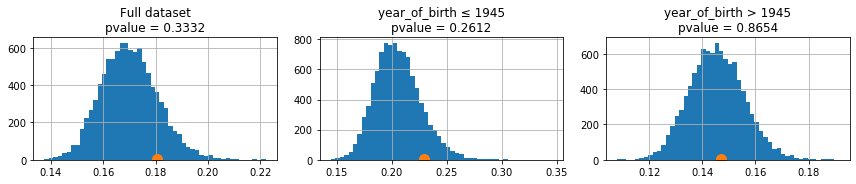

In [71]:
test_all_hyps(
    delta_itm_full,
    delta_itm_perm,
    statistics=(("cumulative bias", "delta_absolute", np.abs, np.mean),),
    figsize=(12, 8 / 3),
)
plt.tight_layout()
plt.savefig("itm-cumulative-bias.png")

In [56]:
ci(delta_itm_bootstrap.groupby("iter")["delta"].mean())

(-0.05473773147472131, 0.037588409636758545)

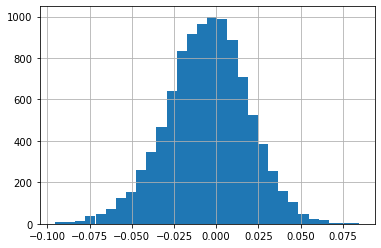

In [76]:
delta_itm_bootstrap.groupby("iter")["delta"].mean().hist(bins=30)